In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import sys
import networkx as nx
import os
import warnings
# matplotlib and seaborn for plotting

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ROOT_PACKAGE_DIRECTORY = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/code/jupyter'
ROOT_DATA_DIRECTORY = ROOT_PACKAGE_DIRECTORY + '/data'
GRAPH_DATABASE_PATH = ROOT_PACKAGE_DIRECTORY + '/data/graph/exp-reuse-same-workload.graph'
sys.path.append(ROOT_PACKAGE_DIRECTORY)

# Experiment Graph
from experiment_graph.execution_environment import ExecutionEnvironment as ee


# Suppress warnings
warnings.filterwarnings('ignore')
% matplotlib inline


try:
    import pygraphviz
    from networkx.drawing.nx_agraph import graphviz_layout
except ImportError:
    try:
        import pydot
        from networkx.drawing.nx_pydot import graphviz_layout
    except ImportError:
        raise ImportError("This example needs Graphviz and either "
                          "PyGraphviz or pydot")

In [2]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Experiment Graph
from sklearn.preprocessing import LabelEncoder

In [3]:
# if os.path.isfile(GRAPH_DATABASE_PATH):
#     print 'Load Existing Experiment Graph!!'
#     ee.load_graph(GRAPH_DATABASE_PATH)
# else:
#     print 'No Experiment Graph Exists!!!'

['.DS_Store', 'graph', 'home-credit-default-risk']
('Training data shape: ', (307511, 122))
('Testing data shape: ', (48744, 121))


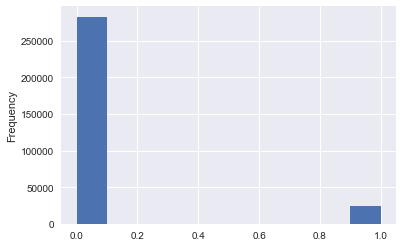

In [4]:
print(os.listdir(ROOT_DATA_DIRECTORY))
app_train = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_train.csv')
print('Training data shape: ', app_train.shape().get())
app_train.head().get()

app_test = ee.load(ROOT_DATA_DIRECTORY + '/home-credit-default-risk/application_test.csv')
print('Testing data shape: ', app_test.shape().get())
app_test.head().get()

app_train['TARGET'].value_counts().get()

app_train['TARGET'].get().astype(int).plot.hist()

In [5]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().get()

    mis_val_percent = 100 * mis_val / len(dataset.get())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data[1]) + " columns.\n"
                                                                          "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [6]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [7]:
app_train.meta['dtypes'].value_counts()

app_train.select_dtypes('object').nunique().get()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [8]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

for col in app_train.select_dtypes('object').get().columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).get() <= 2:
        model = app_train[col].fit_sk_model(le)

        transformed_train = model.transform_col(app_train[col], col)
        app_train = app_train.drop(col)
        app_train = app_train.add_columns(col, transformed_train)

        transformed_test = model.transform_col(app_test[col], col)
        app_test = app_test.drop(col)
        app_test = app_test.add_columns(col, transformed_train)

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [9]:
app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().get())
print('Testing Features shape: ', app_test.shape().get())

train_labels = app_train['TARGET']
for c in app_train.get().columns:
    if c not in app_test.get().columns:
        app_train = app_train.drop(c)

('Training Features shape: ', (307511, 243))
('Testing Features shape: ', (48744, 239))


('Training Features shape: ', (307511, 240))
('Testing Features shape: ', (48744, 239))
The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


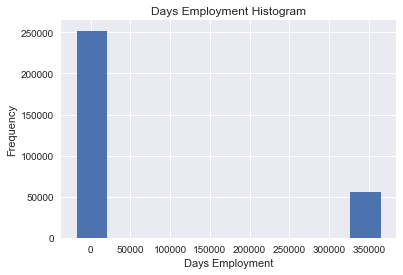

In [10]:
app_train = app_train.add_columns('TARGET', train_labels)

print('Training Features shape: ', app_train.shape().get())
print('Testing Features shape: ', app_test.shape().get())

(app_train['DAYS_BIRTH'] / 365).describe().get()

app_train['DAYS_EMPLOYED'].describe().get()

app_train['DAYS_EMPLOYED'].get().plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().get()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().get()))
print('There are %d anomalous days of employment' % anom.shape().get()[0])


There are 9274 anomalies in the test data out of 48744 entries


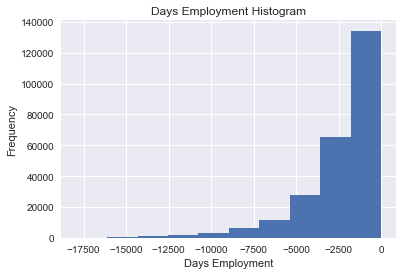

In [11]:
days_employed_anom = app_train['DAYS_EMPLOYED'] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.drop('DAYS_EMPLOYED')
app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

app_train["DAYS_EMPLOYED"].get().plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries'
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().get(),
         app_test.shape().get()[0]))

In [12]:
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.drop('DAYS_BIRTH')
app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).get()

-0.078239308309827088

In [13]:

# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
years_birth = age_data['DAYS_BIRTH'] / 365
age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
binned.setname('YEARS_BINNED')
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).get()

age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups.get()

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


In [14]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr().get()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


In [15]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
imputer_model = poly_features.fit_sk_model(imputer)
poly_features = imputer_model.transform(poly_features)
poly_features_test = imputer_model.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer_model = poly_features.fit_sk_model(poly_transformer)

poly_features = poly_transformer_model.transform(poly_features)
poly_features_test = poly_transformer_model.transform(poly_features_test)

poly_transformer_model.get().get_feature_names(input_features=[
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'
])

# Call manually before meta data update
poly_features.get()
poly_features.set_columns(poly_transformer_model.get().get_feature_names(
    ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features_after = poly_features.add_columns('TARGET', poly_target)


In [17]:
poly_features_after.get().head()

,1,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1^2,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3,EXT_SOURCE_1 DAYS_BIRTH,EXT_SOURCE_2^2,...,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2^2 DAYS_BIRTH,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,EXT_SOURCE_2 DAYS_BIRTH^2,EXT_SOURCE_3^3,EXT_SOURCE_3^2 DAYS_BIRTH,EXT_SOURCE_3 DAYS_BIRTH^2,DAYS_BIRTH^3,TARGET
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,1
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,0
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,0
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,0
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,0
